Use the embedding Binxu generated to find features. Try to find features by classifing contrastive labeled data.

## Ignore this section

In [2]:
saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store"


In [3]:
import os
import pickle

saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store"

latent_file = "red_blue_8_pos_rndembposemb_img_latent_residual_prompt9_seed7.pkl"
latent_path = os.path.join(saveroot, latent_file)

with open(latent_path, 'rb') as f:
    data = pickle.load(f)


In [9]:
import numpy as np

print(data.keys())


dict_keys(['prompt', 'random_seed', 'image_logs', 'latents_traj', 'pred_traj', 't_traj', 'block_11_residual_spatial_state_traj'])


In [16]:
print(data['t_traj'])
print(len(data['block_11_residual_spatial_state_traj']))

[[tensor(999, device='cuda:0'), tensor(928, device='cuda:0'), tensor(856, device='cuda:0'), tensor(785, device='cuda:0'), tensor(714, device='cuda:0'), tensor(642, device='cuda:0'), tensor(571, device='cuda:0'), tensor(500, device='cuda:0'), tensor(428, device='cuda:0'), tensor(357, device='cuda:0'), tensor(285, device='cuda:0'), tensor(214, device='cuda:0'), tensor(143, device='cuda:0'), tensor(71, device='cuda:0')]]
14


blue is below red


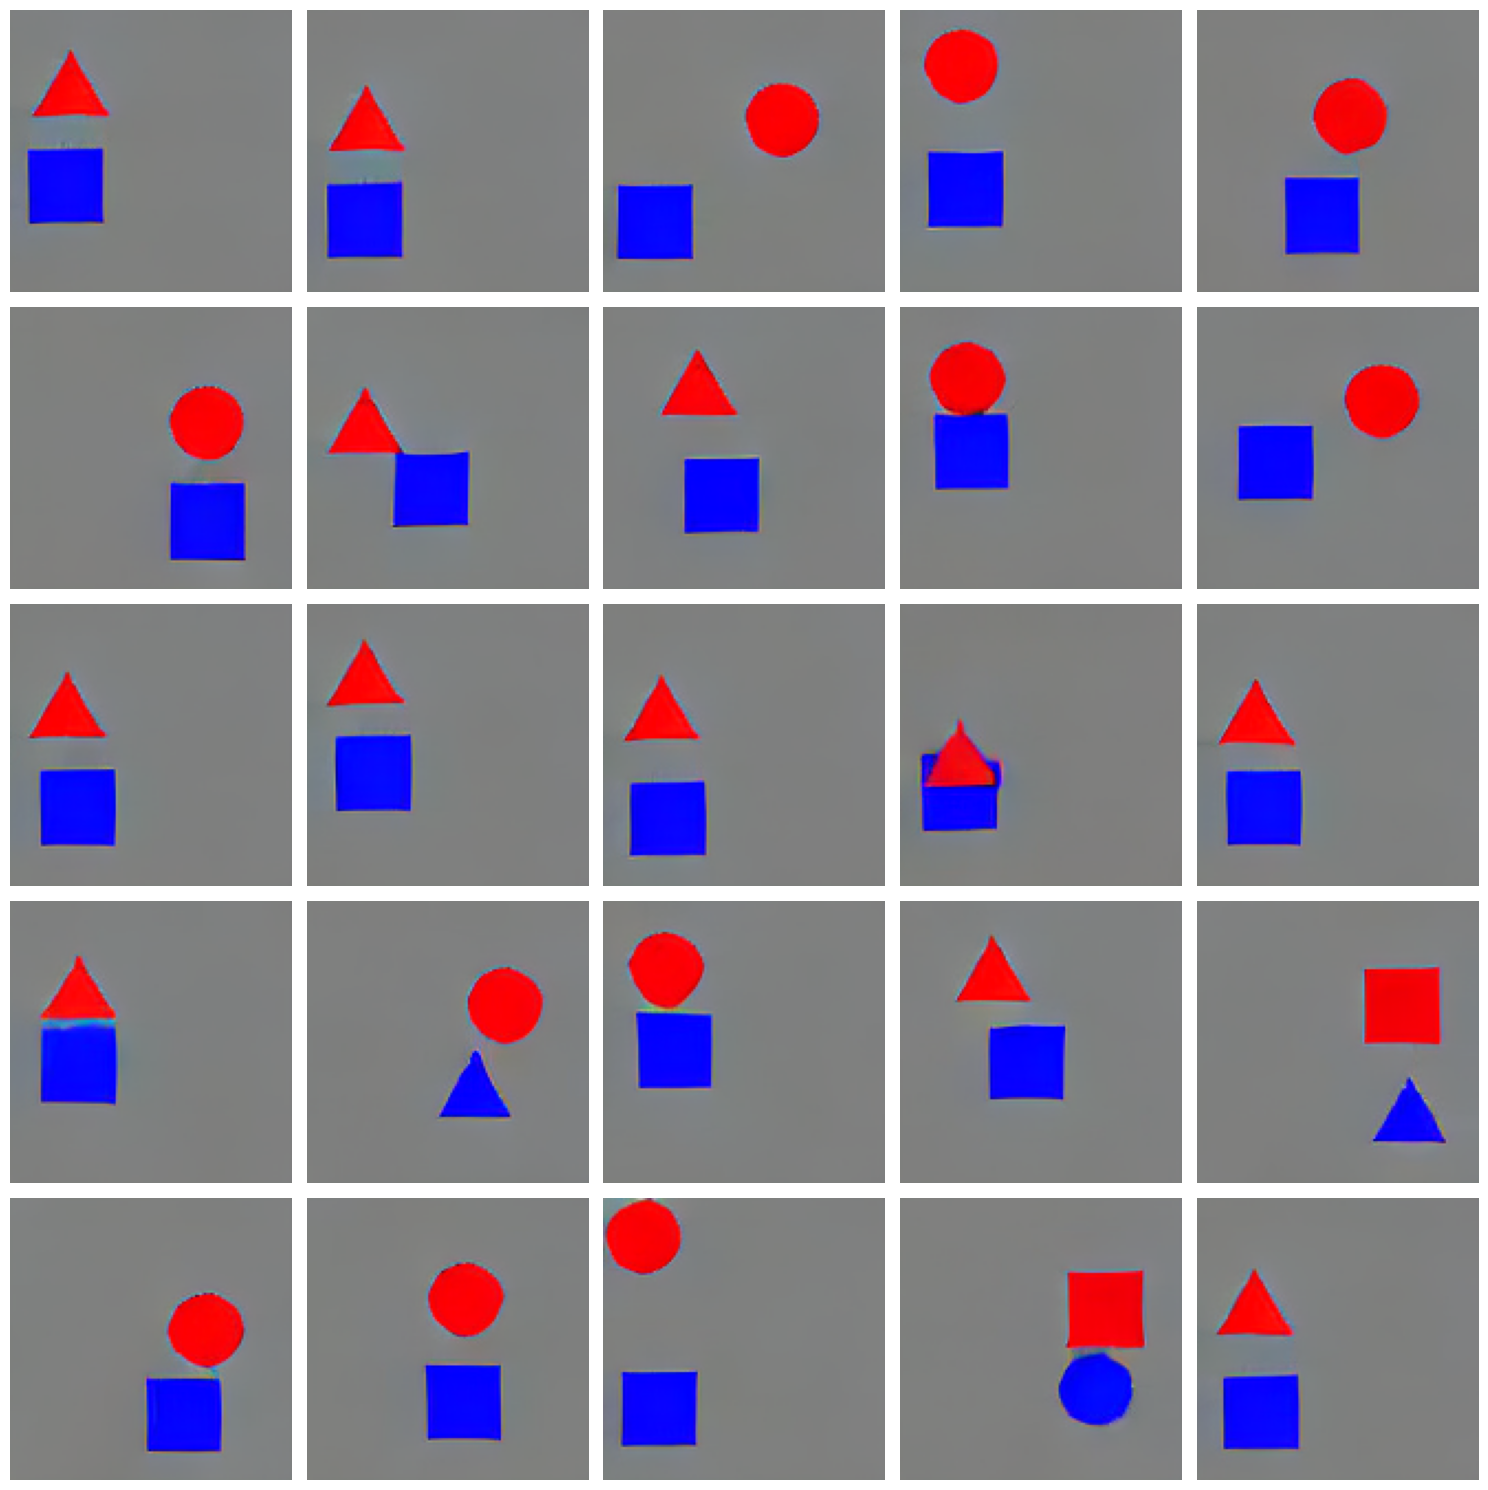

In [49]:
import matplotlib.pyplot as plt
import torch

t_index = 7
print(data['prompt'])
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(data['image_logs'][0]['images'][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

embedding_extracted = data['block_11_residual_spatial_state_traj'][t_index][:25,...]




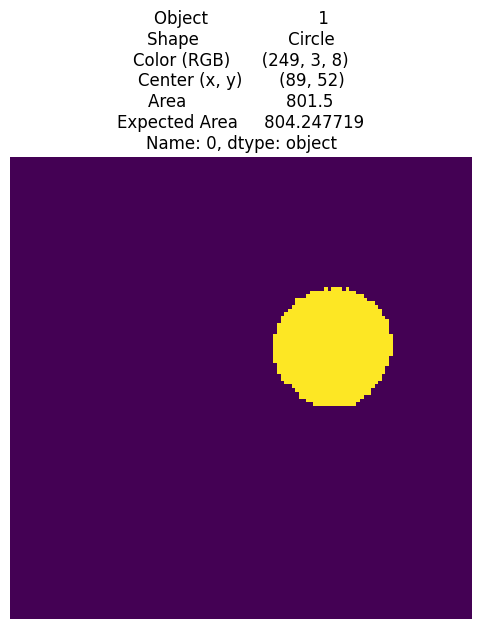

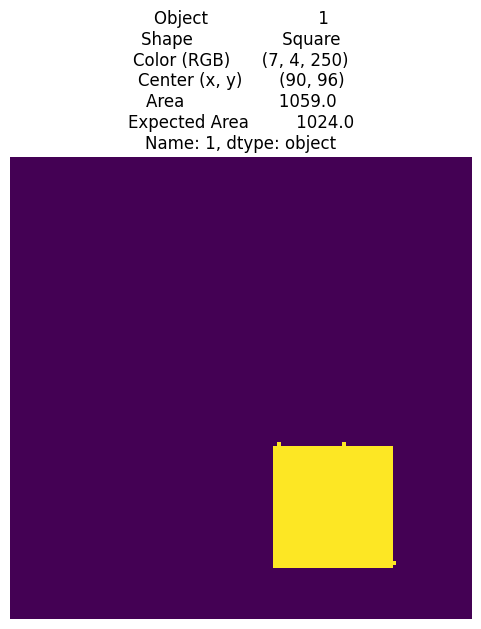

(128, 128) (8, 8) bool
(128, 128) (8, 8) bool


In [51]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image

positive_threshold = 180 

def find_classify_object_masks(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    object_masks = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })
            object_masks.append(mask)

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    assert len(classified_objects_df) == len(object_masks)
    return classified_objects_df, object_masks

obj_df, obj_masks = find_classify_object_masks(data['image_logs'][0]['images'][5])
for i in range(len(obj_df)):
    plt.figure(figsize=(6, 6))
    plt.imshow(obj_masks[i])
    plt.title(obj_df.iloc[i])
    plt.axis('off')
    plt.show()
    
# 180 is the threshold for the object masks, 255 is max. 
for sample_idx in range(len(data['image_logs'][0]['images'])):
    obj_df, obj_masks = find_classify_object_masks(data['image_logs'][0]['images'][sample_idx])
    obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
    obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
    for obj_idx in range(len(obj_df)):  
        print(obj_masks[obj_idx].shape, obj_masks_resized_binary[obj_idx].shape, obj_masks_resized_binary[obj_idx].dtype)        
    break

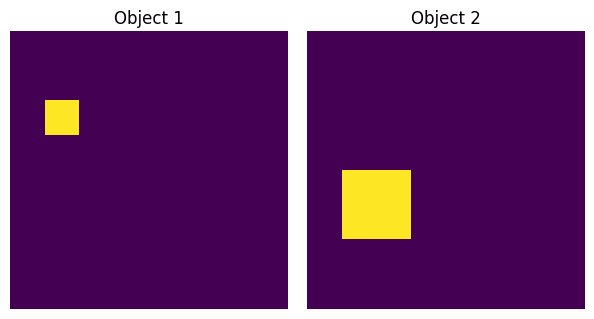

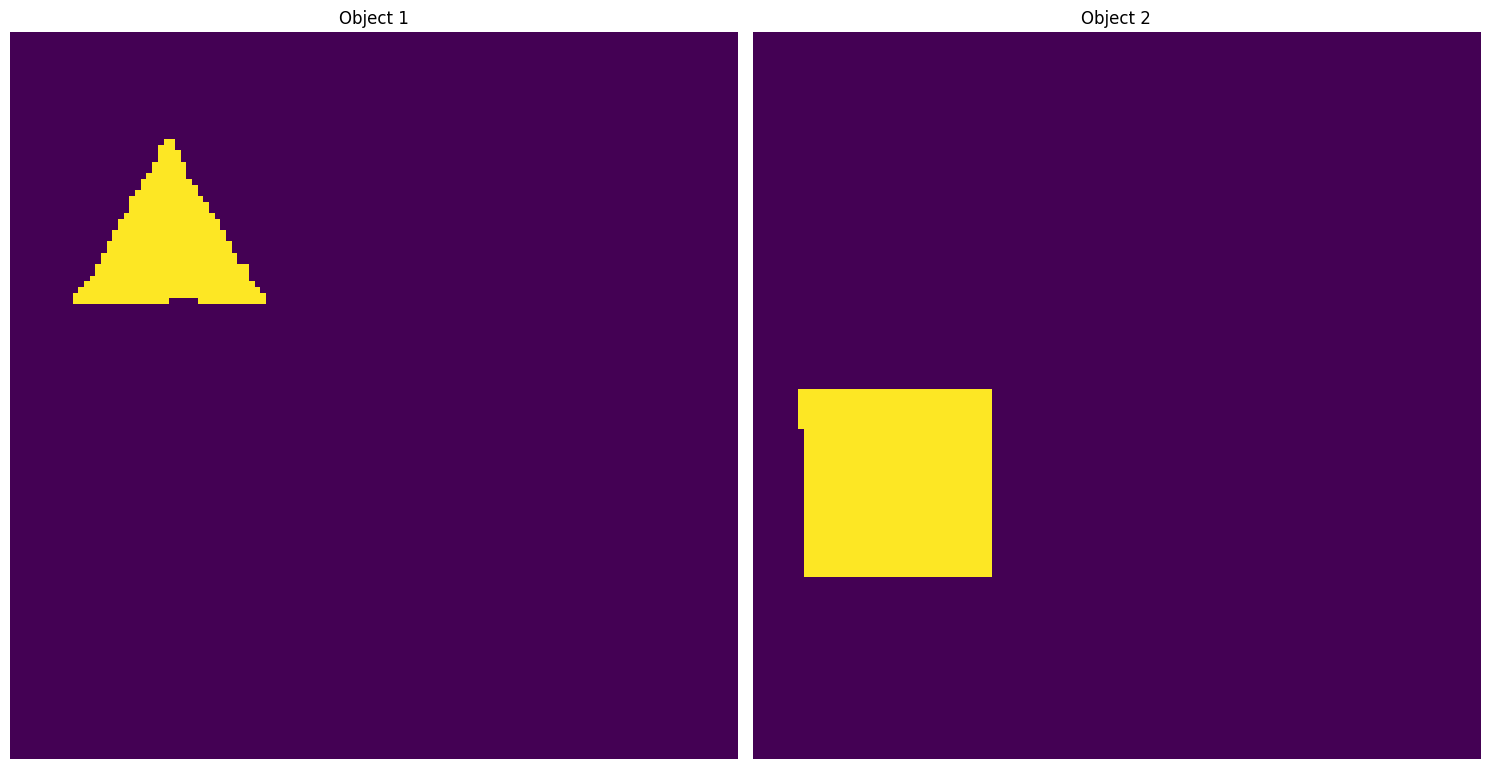

(array([2]), array([1]))
(array([4, 4, 5, 5]), array([1, 2, 1, 2]))


In [56]:
plt.figure(figsize=(15, 15))
for i in range(len(obj_masks_resized_binary)):
    plt.subplot(5, 5, i+1)
    plt.imshow(obj_masks_resized_binary[i])
    plt.title(f"Object {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 15))
for i in range(len(obj_masks)):
    plt.subplot(1, 2, i+1)
    plt.imshow(obj_masks[i])
    plt.title(f"Object {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(len(obj_masks)):
    print(np.array(obj_masks_resized_binary[i]).nonzero())
    


## Read embeddings, extract token embedding based on contrastive classes

In [2]:
import os
import pickle

saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store"

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

positive_threshold = 180 

def find_classify_object_masks(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    object_masks = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })
            object_masks.append(mask)

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    assert len(classified_objects_df) == len(object_masks)
    return classified_objects_df, object_masks

In [3]:
# try to classify top (+) and down (-) objects

positive_embeddings = []
negative_embeddings = []

t_index = 7

# 0,1,8,9 are the prompts that have above or below.
for prompt_idx in [0,1,8,9]:
    for seed_idx in [0,1,2,3,4,5,6,7,8,9]:
        latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
        latent_path = os.path.join(saveroot, latent_file)

        with open(latent_path, 'rb') as f:
            data = pickle.load(f)
        
        for image_idx in range(len(data['image_logs'][0]['images'])):
            obj_df, obj_masks = find_classify_object_masks(data['image_logs'][0]['images'][image_idx])
            if len(obj_df) != 2:
                continue
            obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
            obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
            # if 0 is top, 1 is down
            if obj_df.iloc[0]['Center (x, y)'][1] < obj_df.iloc[1]['Center (x, y)'][1]:
                positive_embeddings.append(data['block_11_residual_spatial_state_traj'][t_index][image_idx][obj_masks_resized_binary[0].nonzero()].numpy())
                negative_embeddings.append(data['block_11_residual_spatial_state_traj'][t_index][image_idx][obj_masks_resized_binary[1].nonzero()].numpy())
            else:
                positive_embeddings.append(data['block_11_residual_spatial_state_traj'][t_index][image_idx][obj_masks_resized_binary[1].nonzero()].numpy())
                negative_embeddings.append(data['block_11_residual_spatial_state_traj'][t_index][image_idx][obj_masks_resized_binary[0].nonzero()].numpy())

positive_embeddings = np.vstack(positive_embeddings)
negative_embeddings = np.vstack(negative_embeddings)

Training accuracy: 0.997
Test accuracy: 0.972


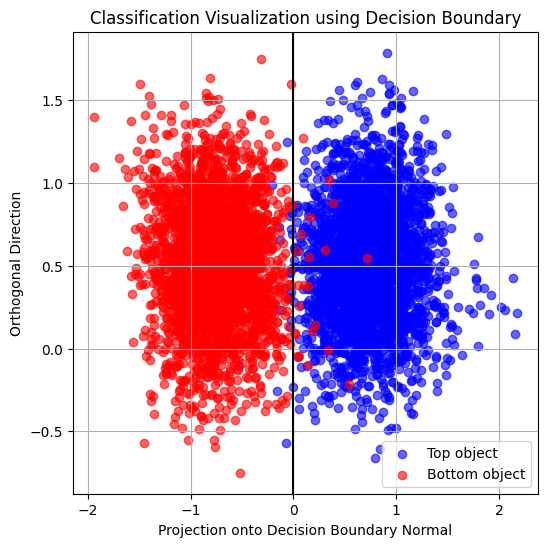

In [4]:
# Combine positive and negative samples
X = np.vstack([positive_embeddings, negative_embeddings])
# Create labels (1 for positive, 0 for negative)
y = np.concatenate([np.ones(len(positive_embeddings)), np.zeros(len(negative_embeddings))])

# Train a linear classifier (using logistic regression)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Evaluate performance
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

# Get the decision boundary normal vector (feature importance)
feature_importance = clf.coef_[0]

# Visualize the classification using boundary normal vector as one axis
# Get the normalized decision boundary vector
boundary_vector = feature_importance / np.linalg.norm(feature_importance)

# Project data onto boundary vector for first dimension
X_boundary = X @ boundary_vector

# Get an orthogonal vector for the second dimension
# Use the first vector that's not parallel to boundary_vector
basis_vector = np.zeros_like(boundary_vector)
basis_vector[0] = 1
orthogonal = basis_vector - (basis_vector @ boundary_vector) * boundary_vector
orthogonal = orthogonal / np.linalg.norm(orthogonal)

# Project data onto orthogonal vector for second dimension
X_orthogonal = X @ orthogonal

# Combine into 2D coordinates
X_proj = np.column_stack([X_boundary, X_orthogonal])

# Split into positive and negative samples
X_pos = X_proj[y==1]
X_neg = X_proj[y==0]

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(X_pos[:, 0], X_pos[:, 1], c='blue', label='Top object', alpha=0.6)
plt.scatter(X_neg[:, 0], X_neg[:, 1], c='red', label='Bottom object', alpha=0.6)

# Plot decision boundary (vertical line at x=0 since boundary_vector is one axis)
plt.axvline(x=0, color='k', linestyle='-')

plt.xlabel('Projection onto Decision Boundary Normal')
plt.ylabel('Orthogonal Direction')
plt.title('Classification Visualization using Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()


## Plot activation of the boundary norm vector